In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils
import RM_utils
import utilities.colormaps as colormaps
import random
import string
import csv
import res_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})


In [2]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'
xticks = [k for k in range(0, len(alph), 3)]
xticklabels = [alph[i] for i in range(0, len(alph), 3)]
D = len(alph)

with open('data/8-letter-words.csv') as f:
    words8 = []
    for row in csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE):
        words8 += row

with open('data/4-letter-words.csv') as f:
    words4 = []
    for row in csv.reader(f, delimiter=',', quoting=csv.QUOTE_NONE):
        words4 += row

In [3]:
def initialize(letter_vecs, state_length=5, n_steps=500):
    N = letter_vecs.shape[1]
    D = letter_vecs.shape[0]

    states = []
    coef_hists = []

    for i in range(state_length):
        states.append(np.random.randn(N))

    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]

    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))

    return states, coef_hists

def resonate_trigram(bound_vec, letter_vecs, state_length=5, max_steps=500):
    th_vec = bound_vec.copy()
    conseq_preds = []
    convstep = max_steps

    states, coef_hists = initialize(letter_vecs, state_length, max_steps)

    #state_length = len(states)
    N = letter_vecs.shape[1]
    D = letter_vecs.shape[0]

    for i in range(max_steps):
        all_converged = np.zeros(state_length-2)
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])

            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                 atol=5e-3, rtol=2e-2)

            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])

        if np.all(all_converged) and convstep == max_steps:
            convstep=i
            #print 'converged:', i,
            #break

        ljds = []
        for j in range(1, state_length-1):
            if j == 1:
                ljds.append(
                    (np.roll(th_vec * states[0] * np.roll(states[2], 2), -1) +
                     th_vec * np.roll(states[2], 1) * np.roll(states[3], 2)) / 2
                )
            elif 1 < j < state_length-2:
                ljds.append(
                    (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                     np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                     th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
                )
            else:
                ljds.append(
                    (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                     np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
                )

        for j in range(1, state_length-1):
            states[j] = np.dot(letter_vecs.T, np.dot(ljds[j-1], letter_vecs.T)/N) #+ 1.0*states[j]
            states[j] = 2.0 * (states[j] > 0) - 1
            #states[j] /= norm(states[j])

    return states, coef_hists, convstep

def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))

def fill_run(words, word_length=8, trials=1, N=1000, n_steps=500):
    all_coefs = []
    all_convcoefs = []
    all_words = []
    all_convwords = []
    all_convsteps = []
    for trial in range(trials):
        for word in words:
            dic1 = 2 * (np.random.randn(D, N) < 0) - 1

            word_vec = RM_utils.ngram_encode_cl(word, dic1, alph)

            states, coef_hists, steps = resonate_trigram(
                word_vec, dic1, word_length+2, n_steps)
            pred, alphis = res_utils.spell(coef_hists)

            conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
            predconv, alphisconv = res_utils.spell(conv_coef_hists)
            #print (pred, predconv, word)
            if pred == word:
                all_coefs.append(coef_hists)
                all_words.append(word)
            if predconv == word:
                all_convcoefs.append(conv_coef_hists)
                all_convwords.append(word)
                all_convsteps.append(steps)
    return all_coefs, all_words, all_convcoefs, all_convwords, all_convsteps
            
def diff_trigram_dict(past2, pres1, pres2, regularized=False):
    psi = np.zeros(N)
    for k in range(past2.shape[0]):
        bound_diff = pres1[k] * (past2[k]-pres2[k])
        if regularized:
            pred = psi*pres1[k] + pres2[k]
            psi += ((N-sim(pred, past2[k]))/float(N)) * bound_diff
        else:
            psi += bound_diff
    return psi

In [4]:
"""
Correct: 
# sigma 0-5: res_word_trigram-noise_vec-04-11-2018-N=10000-D=28-n180423235203.npz
# sigma 5-8: res_word_trigram-noise_vec-04-11-2018-N=10000-D=28-n180428000409.npz

trials = 50
"""

lfiles = ['res_word_trigram-noise_vec-04-11-2018-N=10000-D=28-n180423235203.npz',
          'res_word_trigram-noise_vec-04-11-2018-N=10000-D=28-n180428000409.npz'
         ]
lstats = {'binaccs': [], 'convbinaccs': [], 'convsteps': [], 'convbinaccs': []}
for lf in lfiles:
    f = np.load('data/'+lf)
    
    lstats['binaccs'] += list(f['binaccs'])
    lstats['convbinaccs'] += list(f['convbinaccs'])
    lstats['convsteps'] += list(f['convsteps'])
    

In [5]:
lstats['binaccs'] = np.array(lstats['binaccs'] )
lstats['convbinaccs'] = np.array(lstats['convbinaccs'])
lstats['convsteps'] = np.array(lstats['convsteps'])

In [66]:
def graph(accs, steps, xaxis, sigmas, xlabel, ylabel):
    rows = 1
    columns = 2

    nums = len(sigmas)
    cols = get_cmap("magma", nums)

    yaxis = [i*.1 for i in range(0,11,2)]
    step_yaxis = [i for i in range(0,600,100)]
    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(7,3))

    for i in range(len(accs)):
        axes[0].plot(xaxis, accs[i], c=cols(i), label='$\sigma$='+str(sigmas[i]))
        axes[1].plot(xaxis, steps[i], c=cols(i), label='$\sigma$='+str(sigmas[i]))
        
    axes[0].set_xlabel(xlabel, fontsize=16)
    axes[0].set_ylabel(ylabel, fontsize=16)
    axes[0].set_xticks(xaxis)
    axes[0].set_yticks(yaxis)
    
    axes[1].set_xlabel(xlabel, fontsize=16)
    axes[1].set_ylabel('Steps', fontsize=16)
    axes[1].set_xticks(xaxis)
    axes[1].set_yticks(step_yaxis)
    
    for tick in axes[0].xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
        
    for tick in axes[1].xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
        
    for tick in axes[0].yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
        
    for tick in axes[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 

#     sm = plt.cm.ScalarMappable(cmap=cols)#, norm=plt.Normalize(vmin=0, vmax=1))
#     sm._A = []
#     cbar = fig.colorbar(sm, boundaries= colaxis)
#     cbar.ax.tick_params(labelsize=16) 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.tight_layout()
    
    plt.show()
      

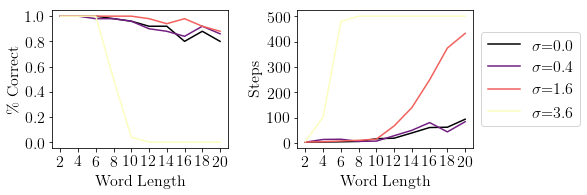

In [67]:
xaxis = [i for i in range(2,22,2)]

sigmas, binaccs, convsteps = [], [], [] 
for i in range(0, lstats['binaccs'].shape[0], 2):
    sigmas.append(.1*(i**2))
    binaccs.append(lstats['binaccs'][i])
    convsteps.append(lstats['convsteps'][i])

graph(binaccs, convsteps, xaxis, sigmas,
     'Word Length', '\% Correct')

In [180]:
tensefiles = ['res_word_trigram_tense-04-11-2018-N=5000-D=28-n180419225339.npz', 
              'res_word_trigram_tense-04-11-2018-N=10000-D=28-n180416205816.npz',
              'res_word_trigram_tense-04-11-2018-N=20000-D=28-n180420120848.npz'
              
             ]
stats = {'binaccs': [], 'convbinaccs': [], 'convsteps': [], 'convbinaccs': []}

for tf in tensefiles:
    f = np.load('data/'+tf)
    
    stats['binaccs'].append(list(f['binaccs']))
    stats['convbinaccs'].append(list(f['convbinaccs']))
    stats['convsteps'].append(list(f['convsteps']))
    
stats['binaccs'] = np.array(stats['binaccs'] )
stats['convbinaccs'] = np.array(stats['convbinaccs'])
stats['convsteps'] = np.array(stats['convsteps'])

((3, 10), (3, 10), (3, 10))


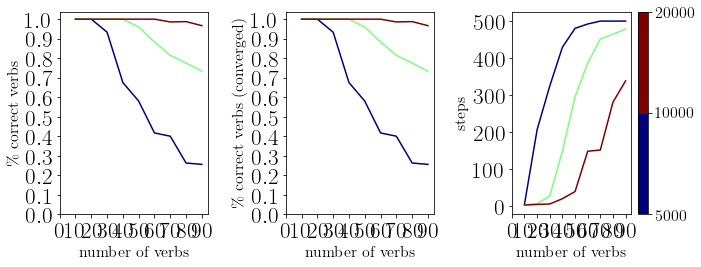

In [181]:

xaxis = [i for i in range(0, stats['binaccs'].shape[1], 10)]
Ns = [5000, 10000, 20000]
accs, convaccs, steps = [], [], []
for i in range(stats['binaccs'].shape[0]):
    accs.append(stats['binaccs'][i][xaxis])
    convaccs.append(stats['convbinaccs'][i][xaxis])
    steps.append(stats['convsteps'][i][xaxis])

graph(np.array(accs), np.array(convaccs), np.array(steps), xaxis, Ns,
     'number of verbs', '\% correct verbs')


In [11]:
pres = []
past = []
for key in RM_utils.past_categories.keys():
    pres += RM_utils.pres_categories[key]
    past += RM_utils.past_categories[key] 

In [20]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'
D = len(alph)
N = 20000

dic1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = 2 * (np.random.randn(D, N) < 0) - 1

In [21]:
pres1 = np.zeros((len(past), N))
pres2 = np.zeros((len(past), N))
past1 = np.zeros((len(past), N))
past2 = np.zeros((len(past), N))

for m in range(len(past)):
    pres1[m] = RM_utils.ngram_encode_cl(pres[m], dic1, alph)
    pres2[m] = RM_utils.ngram_encode_cl(past[m], dic2, alph)
    past1[m] = RM_utils.ngram_encode_cl(past[m], dic1, alph)
    past2[m] = RM_utils.ngram_encode_cl(past[m], dic2, alph)


In [22]:
accs = []
binaccs = []
convsteps = []

convaccs = []
convbinaccs = []

In [ ]:
for i in range(len(past)):
    print ('i', i)
    avg_per_acc = np.zeros(i)
    avg_bin_acc = np.zeros(i)
    avg_per_convacc = np.zeros(i)
    avg_bin_convacc = np.zeros(i)
    avg_steps = np.zeros(i)
    diff_psi_irreg = diff_trigram_dict(past2[:i],
                                   pres1[:i],
                                   pres2[:i])
    for j in range(i):
        pred_vec = pres1[j] * diff_psi_irreg + pres2[j]
        states, coef_hists, convstep = resonate_trigram(pred_vec, dic2, len(past[j])+2)
        conv_coef_hists = [coef_hists[k][:convstep] for k in range(len(coef_hists))]
        pred, alphis = res_utils.spell(coef_hists)
        predconv, alphisconv = res_utils.spell(conv_coef_hists)

        avg_per_acc[j] = accuracy(pred, past[j])
        avg_bin_acc[j] = 1 if pred == past[j] else 0
        avg_per_convacc[j] = accuracy(predconv, past[j])
        avg_bin_convacc[j] = 1 if predconv == past[j] else 0
        avg_steps[j] = convstep
        print (pred, predconv, past[j])
    accs.append(np.average(avg_per_acc))
    binaccs.append(np.average(avg_bin_acc))
    convaccs.append(np.average(avg_per_convacc))
    convbinaccs.append(np.average(avg_bin_convacc))
    convsteps.append(np.average(avg_steps))

    

('i', 0)
('i', 1)
('beat', 'beat', 'beat')
('i', 2)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('i', 3)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('i', 4)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('spread', 'spread', 'spread')
('i', 5)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('spread', 'spread', 'spread')
('hit', 'hit', 'hit')
('i', 6)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('spread', 'spread', 'spread')
('hit', 'hit', 'hit')
('cut', 'cut', 'cut')
('i', 7)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('spread', 'spread', 'spread')
('hit', 'hit', 'hit')
('cut', 'cut', 'cut')
('put', 'put', 'put')
('i', 8)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('spread', 'spread', 'spread')
('hit', 'hit', 'hit')
('cut', 'cut', 'cut')
('put', 'put', 'put')
('thrust', 'thrust', 'thrust')
('i', 9)
('beat', 'beat', 'beat')
('fit', 'fit', 

('became', 'became', 'became')
('bore', 'bore', 'bore')
('wore', 'wore', 'wore')
('spoke', 'spoke', 'spoke')
('broke', 'broke', 'broke')
('drove', 'drove', 'drove')
('sm#uck', 'sm#uck', 'struck')
('fell', 'fell', 'fell')
('froze', 'froze', 'froze')
('chose', 'chose', 'chose')
('tore', 'tore', 'tore')
('i', 89)
('beat', 'beat', 'beat')
('fit', 'fit', 'fit')
('set', 'set', 'set')
('spread', 'spread', 'spread')
('hit', 'hit', 'hit')
('cut', 'cut', 'cut')
('put', 'put', 'put')
('thrust', 'thrust', 'thrust')
('bid', 'bid', 'bid')
('built', 'built', 'built')
('sent', 'sent', 'sent')
('spent', 'spent', 'spent')
('bent', 'bent', 'bent')
('lent', 'lent', 'lent')
('felt', 'felt', 'felt')
('dealt', 'dealt', 'dealt')
('did', 'did', 'did')
('fled', 'fled', 'fled')
('told', 'told', 'told')
('sold', 'sold', 'sold')
('heard', 'heard', 'heard')
('kept', 'kept', 'kept')
('left', 'left', 'left')
('slept', 'slept', 'slept')
('lost', 'lost', 'lost')
('meant', 'meant', 'meant')
('said', 'said', 'said')
('sw

('wept', 'wept', 'wept')
('had', 'had', 'had')
('made', 'made', 'made')
('thought', 'thought', 'thought')
('bought', 'bought', 'bought')
('brpnrht', 'brpnrht', 'brought')
('sought', 'sought', 'sought')
('taught', 'taught', 'taught')
('caught', 'caught', 'caught')
('got', 'got', 'got')
('met', 'met', 'met')
('shot', 'shot', 'shot')
('wrote', 'wrote', 'wrote')
('lead', 'lead', 'lead')
('unp#alrood', 'unp#alrood', 'understood')
('sat', 'sat', 'sat')
('misled', 'misled', 'misled')
('bled', 'bled', 'bled')
('fed', 'fed', 'fed')
('stood', 'stood', 'stood')
('lit', 'lit', 'lit')
('found', 'found', 'found')
('fouyly', 'fouyly', 'fought')
('read', 'read', 'read')
('met', 'met', 'met')
('hid', 'hid', 'hid')
('held', 'held', 'held')
('rode', 'rode', 'rode')
('bred', 'bred', 'bred')
('wound', 'wound', 'wound')
('ground', 'ground', 'ground')
('drank', 'drank', 'drank')
('rang', 'rang', 'rang')
('sang', 'sang', 'sang')
('swam', 'swam', 'swam')
('drug', 'drug', 'drug')
('hung', 'hung', 'hung')
('swun

('drank', 'drank', 'drank')
('rang', 'rang', 'rang')
('sang', 'sang', 'sang')
('swam', 'swam', 'swam')
('drug', 'drug', 'drug')
('hung', 'hung', 'hung')
('swung', 'swung', 'swung')
('dug', 'dug', 'dug')
('clung', 'clung', 'clung')
('stuck', 'stuck', 'stuck')
('gave', 'gave', 'gave')
('took', 'took', 'took')
('came', 'came', 'came')
('shook', 'shook', 'shook')
('arose', 'arose', 'arose')
('rose', 'rose', 'rose')
('ran', 'ran', 'ran')
('became', 'became', 'became')
('bore', 'bore', 'bore')
('wore', 'wore', 'wore')
('spoke', 'spoke', 'spoke')
('broke', 'broke', 'broke')
('drove', 'drove', 'drove')
('sttack', 'sttack', 'struck')
('fell', 'fell', 'fell')
('froze', 'froze', 'froze')
('chose', 'chose', 'chose')
('tore', 'tore', 'tore')
('went', 'went', 'went')
('threw', 'threw', 'threw')
('blew', 'blew', 'blew')
('grew', 'grew', 'grew')
('drew', 'drew', 'drew')
('flew', 'flew', 'flew')
('knew', 'knew', 'knew')


In [26]:
fname = ('data/res_word_trigram_tense-04-11-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps, convaccs=convaccs, convbinaccs=convbinaccs, N=N, D=D)


In [ ]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'
D = len(alph)

N = 10000
n_steps = 500
trials = 50

accs = []
binaccs = []
convsteps = []
convaccs = []
convbinaccs = []
# have done a version without noise

# noise
for h in range(5):
    sigma = .1 * (h**2)
    print ('sigma', sigma)
    accs.append([])
    binaccs.append([])
    convsteps.append([])
    convaccs.append([])
    convbinaccs.append([])
    
    dic1 = 2 * (np.random.randn(D, N) < 0) - 1

    # M-letter word
    for word_length in range(2,22,2):
        print ('word_length', word_length)
        avg_per_acc = []
        avg_bin_acc = []
        avg_conv_steps = []
        avg_conv_per_acc = []
        avg_conv_bin_acc = []

        # average results
        for trial in range(trials):
            word = ''.join(random.choice(string.lowercase) for j in range(word_length))
            noise = np.random.normal(0,sigma)
            word_vec = RM_utils.ngram_encode_cl(word, dic1, alph) + noise

            states, coef_hists, convstep = resonate_trigram(word_vec, dic1, word_length+2)
            conv_coef_hists = [coef_hists[k][:convstep] for k in range(len(coef_hists))]
            pred, alphis = res_utils.spell(coef_hists)
            predconv, alphisconv = res_utils.spell(conv_coef_hists)

            avg_per_acc.append(accuracy(pred, word))
            avg_bin_acc.append(1 if pred == word else 0)


            avg_conv_steps.append(convstep)
            avg_conv_per_acc.append(accuracy(predconv, word))
            avg_conv_bin_acc.append(1 if predconv == word else 0)

        accs[h].append( np.average(avg_per_acc))
        binaccs[h].append( np.average(avg_bin_acc))

        convsteps[h].append( np.average(avg_conv_steps))
        convaccs[h].append( np.average(avg_conv_per_acc))
        convbinaccs[h].append( np.average(avg_conv_bin_acc))
        #print ('word_length', word_length, accs[sigma][i], binaccs[sigma][i], convsteps[sigma][i])

('sigma', 0.0)
('word_length', 2)
('word_length', 4)
('word_length', 6)
('word_length', 8)
('word_length', 10)
('word_length', 16)
('word_length', 18)
('word_length', 20)


KeyboardInterrupt: 

In [51]:
fname = ('data/res_word_trigram-04-11-2018-N=' + str(N) + '-D=' + str(D) + 
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, accs=accs, binaccs=binaccs, convsteps=convsteps, convaccs=convaccs, convbinaccs=convbinaccs, N=N, D=D)


In [ ]:
f = np.load('data/res_word_trigram-04-11-2018-N=8000-D=28-n180417105037.npz')

In [21]:
# 3
all_coefs, all_words, all_convcoefs, all_convwords, all_convsteps = fill_run(words8, 8)

converged: 75 converged: 28 converged: 58 converged: 51 converged: 60 converged: 66 converged: 63 converged: 32 converged: 28 converged: 31 converged: 34 converged: 47 converged: 9 converged: 51 converged: 23 converged: 65 converged: 23 converged: 37 converged: 40 converged: 95 converged: 68 converged: 33 converged: 43 converged: 49 converged: 28 converged: 28 converged: 111 converged: 50 converged: 24 converged: 46 converged: 46 converged: 66 converged: 59 converged: 62 converged: 76 converged: 67 converged: 77 converged: 64 converged: 25 converged: 54 converged: 40 converged: 147


In [22]:
# 2.a get probabilities of fill patterns

# divide steps into quartiles. assume steps.shape[0] is divisible by 4
def check_conds(steps):
    quarter = int(steps.shape[0]/4)
    mid = int(steps.shape[0]/2)
    q1 = np.sum(steps[:quarter])
    q2 = np.sum(steps[quarter:mid])
    q3 = np.sum(steps[mid:mid+quarter])
    q4 = np.sum(steps[steps.shape[0]-quarter:])
    # H0 = out to in
    if q1 + q4 < q1 + q2:
        return 0
    # H1 = front to back
    if q1 + q2 <= q3 + q4:
        return 1
    # H2 = back to front
    if q3 + q4 <= q1 + q2:
        return 2
    # H3 = in to out
    if q1 + q2 <= q1 + q4:
        return 3
    return -1

def fill_probs(coefs_list):
    probs = np.zeros(4)
    for i in range(len(coefs_list)):
        letter_convsteps = []
        for j in range(len(coefs_list[i])):
            pred, alphis = res_utils.spell(coefs_list[i])
            idx = np.argmax(coefs_list[i][j][:, alphis[j]])
            letter_convsteps.append(idx)
        probs[check_conds(np.array(letter_convsteps))] += 1
        #print letter_convsteps
    probs /= float(len(coefs_list))
    return probs

probs = fill_probs(all_coefs)
conv_probs = fill_probs(all_convcoefs)


In [23]:
"""
word_length = 8
probs: [ 0.58333333  0.375       0.04166667  0.        ]
conv_probs: [ 0.58333333  0.375       0.04166667  0.        ]

word_length = 4
probs: [ 0.2020202  0.5959596  0.2020202  0.       ]
conv_probs: [ 0.2020202  0.5959596  0.2020202  0.       ]
"""
print probs
print conv_probs

[ 0.58333333  0.375       0.04166667  0.        ]
[ 0.58333333  0.375       0.04166667  0.        ]


In [71]:
# 2.b graph heatmaps
def update_found(coefs_list):
    found = np.zeros(4)
    found_idxs = np.zeros(4)
    for i in range(len(coefs_list)):
        letter_convsteps = []
        for j in range(len(coefs_list[i])):
            pred, alphis = res_utils.spell(coefs_list[i])
            idx = np.argmax(coefs_list[i][j][:, alphis[j]])
            letter_convsteps.append(idx)
        cidx = check_conds(np.array(letter_convsteps))
        if found[cidx] == 0:
            found[cidx] = 1
            found_idxs[cidx] = i
    return found, found_idxs

def update_examples(coefs_list, found, exs, convsteps=[], all_convsteps=[]):
    fd, i = update_found(coefs_list)
    nfound = np.logical_or(found, fd)
    
    pts = np.where(fd == 1)[0]
    for j in range(pts.shape[0]):
        pt = int(pts[j])
        exs[pt].append(coefs_list[int(i[pt])])
        if len(all_convsteps) > 0:
            convsteps[pt].append(all_convsteps[int(i[pt])])

    return nfound, exs, convsteps
            
def fill_examples(words, word_length, trials):
    found = np.zeros(4)
    convfound = np.zeros(4)
    
    exs = [[] for i in range(4)]
    convexs = [[] for i in range(4)]
    convsteps = [[] for i in range(4)]
    for i in range(10):
#     while not (np.sum(found) >= 3 and np.sum(convfound) >= 3):
#     while not (np.sum(found) >= 2 and np.sum(convfound) >= 2):
        all_coefs, all_words, all_convcoefs, all_convwords, all_convsteps = fill_run(words, word_length, trials)
        if not np.all(found):
            found, exs, cs = update_examples(all_coefs, found, exs)
        if not np.all(convfound):
            convfound, convexs, convsteps = update_examples(all_convcoefs, convfound, convexs, convsteps, all_convsteps)
        print (found, convfound)
    return found, exs, convfound, convexs, convsteps
     
found, exs, convfound, convexs, convsteps = fill_examples(words4, 4, 1)
# for i in range(len(all_coefs)):
#     resplot_im(all_coefs[i])
# for i in range(len(all_conv_coefs)):
#     resplot_im(all_convcoefs[i])


(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))
(array([ True,  True,  True, False], dtype=bool), array([ True,  True,  True, False], dtype=bool))


In [49]:
fname = ('data/res_word_trigram-04-11-2018-N=1000-D=28-word_length=8' +
         '-n' + time.strftime('%y%m%d%H%M%S') + '.npz')

np.savez(fname, found=found, exs=exs, convfound=convfound, convexs=convexs, convsteps=convsteps, N=1000, D=28)


In [50]:
# explain away version
# f4 = np.load('data/res_word_trigram-04-07-2018-N=1000-D=28-n180408194310.npz')
# f4 = np.load('data/res_word_trigram-04-07-2018-N=1000-D=28-n180408204440.npz')

f = np.load('data/res_word_trigram-04-11-2018-N=1000-D=28-word_length=4-n180411132926.npz')
# f = np.load('data/res_word_trigram-04-11-2018-N=1000-D=28-word_length=8-n180411133239.npz')

In [51]:
found = f['found']
exs = f['exs']
convfound = f['convfound']
convexs = f['convexs']
convsteps = f['convsteps']

In [76]:
def resplot_im(coef_hists,
              title,
              nsteps,
              N,
              cond):
    pred, alphis = res_utils.spell(coef_hists)
    rows = 1
    columns = len(coef_hists)

    fig = plt.figure(figsize=(10, 4))
    ax = columns * [0]
    
    x_idxs = list(np.arange(0, len(alph), 4))
    x_labels = np.array(list(alph))[x_idxs]  
        
    for j in range(columns):
        ax[j] = fig.add_subplot(rows, columns, j+1)

        a = np.sign(coef_hists[j][-1,alphis[j]])
        coef_hists[j][:,alphis[j]] *= a
        
        x_h = coef_hists[j][:,:]
        
        imh = ax[j].imshow(x_h, interpolation='none', aspect='auto', cmap=colormaps.viridis)
        
        if j == 0:
            ax[j].set_ylabel('Iterations')
        else: 
            ax[j].set_yticks([])
        ax[j].set_xticks(x_idxs)
        ax[j].set_xticklabels(x_labels)           
        ax[j].set_title(alph[alphis[j]])


#     colorbar(imh, ticks=[])

#     fname = 'figures/res_im-'+title+'-'+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-cond='+str(cond) +'-n' + time.strftime('%y%m%d')
#     savefig(fname + '.png', format='png', transparent=True)
#     savefig(fname + '.eps', format='eps', transparent=True)

    plt.tight_layout()

In [80]:
print found
print len(exs[2])
print convfound
print len(convexs)
print len(convsteps)

"""
resplot_im(coef_hists,
              title,
              nsteps,
              N,
              cond,
              start=0):
"""

pts = np.where(found == 1)[0]
for i in range(pts.shape[0]):
    for j in range(2):#len(exs[int(pts[i])])):
        print exs[int(pts[i])][j][0].shape
#         resplot_im(exs[int(pts[i])][j],
#                   'fill_pattern-conv=False',
#                   500,
#                   1000,
#                   i)

# pts = np.where(convfound == 1)[0]
# for i in range(pts.shape[0]):
#     for j in range(len(convexs[int(pts[i])])):
#         steps = convsteps[int(pts[i])][j]
#         coef_hists = convexs[int(pts[i])][j]
#         conv_coef_hists = [coef_hists[j][:steps] for j in range(len(coef_hists))]
#         resplot_im(conv_coef_hists,
#                    'fill_pattern',
#                    steps,
#                    1000,
#                    i)


[ True  True  True False]
10
[ True  True  True False]
4
4
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
(500, 28)
